In [273]:
import os
import random
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split

random.seed(1)

In [274]:
# Read in MIMIC files
raw_adm = pd.read_csv("/home/dc925/project/data/graphmimic/MIMIC/ADMISSIONS.csv")
raw_patients = pd.read_csv('/home/dc925/project/data/graphmimic/MIMIC/PATIENTS.csv.gz')
dicd = pd.read_csv('/home/dc925/project/data/graphmimic/MIMIC/DIAGNOSES_ICD.csv.gz')
picd = pd.read_csv('/home/dc925/project/data/graphmimic/MIMIC/PROCEDURES_ICD.csv.gz')
raw_notes = pd.read_csv("/home/dc925/project/data/graphmimic/MIMIC/NOTEEVENTS.csv")

# Only keep the admission IDs that have notes
adm = raw_adm.copy()
adm_in_notes = raw_notes.HADM_ID.unique()
adm = adm[adm.HADM_ID.isin(adm_in_notes)]
# Subset notes to nursing and physician notes
notes = raw_notes.copy()
categories_keep = ['Nursing', 'Physician ', 'Nursing/other']
notes = notes[notes.CATEGORY.isin(categories_keep)]
# Merge notes with patient data
notes = notes.merge(
    adm[['HADM_ID', 'DISCHTIME', 'HOSPITAL_EXPIRE_FLAG']],
    on='HADM_ID', how='left'
)
# Time manipulation to only keep notes more than 24 hrs before discharge
notes.DISCHTIME = pd.to_datetime(notes.DISCHTIME)
notes.CHARTTIME = pd.to_datetime(notes.CHARTTIME)
notes.CHARTDATE = pd.to_datetime(notes.CHARTDATE) + pd.DateOffset(hours=23)
notes.CHARTTIME = notes.CHARTTIME.fillna(notes.CHARTDATE)
notes = notes[notes.CHARTTIME < notes.DISCHTIME - pd.DateOffset(hours=24)]

/home/dc925/miniconda3/envs/graphmimic/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3147: DtypeWarning: Columns (4,5) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [275]:
# Subset relevant columns and create balanced dataset
keep_cols = ['HADM_ID', 'SUBJECT_ID', 'TEXT', 'HOSPITAL_EXPIRE_FLAG']
pos_notes = notes.loc[notes.HOSPITAL_EXPIRE_FLAG == 1, keep_cols]
neg_notes = (
    notes
    .loc[:, keep_cols]
    .query("HOSPITAL_EXPIRE_FLAG == 0")
    .groupby("HADM_ID")
    .apply(lambda df: df.sample(n=4) if df.shape[0] >= 4 else df)
    .reset_index(drop=True)
)
sampled_notes = pd.concat([pos_notes, neg_notes]).drop_duplicates()
sampled_notes.HOSPITAL_EXPIRE_FLAG.value_counts()

0.0    135498
1.0    124702
Name: HOSPITAL_EXPIRE_FLAG, dtype: int64

In [276]:
# Get ICD-9 codes per visit and merge with notes
gp = dicd.groupby('HADM_ID')
icd_codes = gp['ICD9_CODE'].apply(list)
icd_codes = icd_codes.reset_index()
sampled_notes = sampled_notes.merge(
    icd_codes,
    on='HADM_ID', how='left')
# Function to convert ICD9 codes to broader version (take the first 3 characters; first 4 characters for E-codes)
def simplify_icd(code_list):
    new_list = []
    for code in code_list:
        code = str(code)
        if code=='nan':
            continue
        if code[0]=='E':
            new_code = code[:4]
        else:
            new_code = code[:3]
        new_list.append(new_code)
    return new_list
sampled_notes['BROAD_ICD9_CODE'] = sampled_notes['ICD9_CODE'].apply(lambda x: simplify_icd(x))

In [277]:
sampled_notes.shape

(260200, 6)

In [278]:
# Count unique broad ICD9 codes
from collections import Counter
broad_codes = sampled_notes['BROAD_ICD9_CODE']
bc = list(broad_codes)
all_codes = [item for sublist in bc for item in sublist]
c = Counter(all_codes)
len(c)

1033

In [279]:
# Clean text
def isolate(text, chars):
    for c in chars:
        text = text.replace(c, f" {c} ")
    return text
def replace(text, chars, new=""):
    for c in chars:
        text = text.replace(c, new)
    return text
def clean_text(text):
    text = replace(text, "[**")
    text = replace(text, "**]")
    text = isolate(text, "~!@#$%^&*()_+-={}:\";',./<>?\\|`'")
    text = text.lower()
    return text

In [280]:
sampled_notes['TEXT'] = sampled_notes.TEXT.apply(clean_text)

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (791 > 512). Running this sequence through the model will result in indexing errors


<AxesSubplot:ylabel='Frequency'>

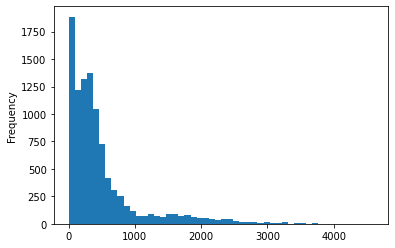

In [253]:
# # this is for counting num tokens to see distribution of lengths
# from transformers import AutoTokenizer, BertTokenizer
# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# sample = sampled_notes.sample(10000)
# sample['tokens'] = sample['TEXT'].apply(lambda x: tokenizer(x)['input_ids'])
# sample['length'] = sample['tokens'].apply(lambda x: len(x))
# sample['length'].plot.hist(bins=50)

In [281]:
final_sampled_notes = sampled_notes[['HADM_ID', 'SUBJECT_ID', 'TEXT', 'BROAD_ICD9_CODE', 'HOSPITAL_EXPIRE_FLAG']]

In [282]:
final_sampled_notes = final_sampled_notes.rename(columns={'HOSPITAL_EXPIRE_FLAG': 'OUTPUT_LABEL'})

In [283]:
final_sampled_notes.head()

,HADM_ID,SUBJECT_ID,TEXT,BROAD_ICD9_CODE,OUTPUT_LABEL
0,146431.0,31916,"respiratory failure , acute ( not ards / doc...","[507, 518, 552, 197, 198, 198, 584, 511, V66, ...",1.0
1,116532.0,29487,chief complaint : \n 24 hour events : \n ekg...,"[038, 518, 785, 428, 486, 276, 599, 584, 707, ...",1.0
2,116532.0,29487,no significant events overnight\n renal fail...,"[038, 518, 785, 428, 486, 276, 599, 584, 707, ...",1.0
3,111458.0,31820,"sepsis , severe ( with organ dysfunction ) \...","[197, 584, 157, 511, 599, 038, 558, 286, 518, ...",1.0
4,116532.0,29487,"chief complaint : urosepsis , erspiratory fa...","[038, 518, 785, 428, 486, 276, 599, 584, 707, ...",1.0


In [284]:
final_sampled_notes['BROAD_ICD9_CODE'] = final_sampled_notes['BROAD_ICD9_CODE'].apply(lambda x: ['ICD'+c for c in x])

In [285]:
final_sampled_notes.head()

,HADM_ID,SUBJECT_ID,TEXT,BROAD_ICD9_CODE,OUTPUT_LABEL
0,146431.0,31916,"respiratory failure , acute ( not ards / doc...","[ICD507, ICD518, ICD552, ICD197, ICD198, ICD19...",1.0
1,116532.0,29487,chief complaint : \n 24 hour events : \n ekg...,"[ICD038, ICD518, ICD785, ICD428, ICD486, ICD27...",1.0
2,116532.0,29487,no significant events overnight\n renal fail...,"[ICD038, ICD518, ICD785, ICD428, ICD486, ICD27...",1.0
3,111458.0,31820,"sepsis , severe ( with organ dysfunction ) \...","[ICD197, ICD584, ICD157, ICD511, ICD599, ICD03...",1.0
4,116532.0,29487,"chief complaint : urosepsis , erspiratory fa...","[ICD038, ICD518, ICD785, ICD428, ICD486, ICD27...",1.0


In [286]:
# Get splits and ids
subjects = final_sampled_notes[['SUBJECT_ID', "OUTPUT_LABEL"]].drop_duplicates()

train_subj, rest_subj = train_test_split(
    subjects, 
    test_size=0.25, 
    random_state=0,
    stratify=subjects.OUTPUT_LABEL
)

valid_subj, test_subj = train_test_split(
    rest_subj.SUBJECT_ID.values,
    test_size=0.6,
    random_state=1,
    stratify=rest_subj.OUTPUT_LABEL
)

train_subj = train_subj.SUBJECT_ID.values

In [287]:
train_notes = final_sampled_notes[final_sampled_notes.SUBJECT_ID.isin(train_subj)].reset_index(drop=True)
valid_notes = final_sampled_notes[final_sampled_notes.SUBJECT_ID.isin(valid_subj)].reset_index(drop=True)
test_notes = final_sampled_notes[final_sampled_notes.SUBJECT_ID.isin(test_subj)].reset_index(drop=True)

In [288]:
train_notes = train_notes[['HADM_ID', 'TEXT', 'BROAD_ICD9_CODE', 'OUTPUT_LABEL']]
valid_notes = valid_notes[['HADM_ID', 'TEXT', 'BROAD_ICD9_CODE', 'OUTPUT_LABEL']]
test_notes = test_notes[['HADM_ID', 'TEXT', 'BROAD_ICD9_CODE', 'OUTPUT_LABEL']]

In [289]:
train_notes

,HADM_ID,TEXT,BROAD_ICD9_CODE,OUTPUT_LABEL
0,116532.0,chief complaint : \n 24 hour events : \n ekg...,"[ICD038, ICD518, ICD785, ICD428, ICD486, ICD27...",1.0
1,116532.0,no significant events overnight\n renal fail...,"[ICD038, ICD518, ICD785, ICD428, ICD486, ICD27...",1.0
2,111458.0,"sepsis , severe ( with organ dysfunction ) \...","[ICD197, ICD584, ICD157, ICD511, ICD599, ICD03...",1.0
3,116532.0,"chief complaint : urosepsis , erspiratory fa...","[ICD038, ICD518, ICD785, ICD428, ICD486, ICD27...",1.0
4,116532.0,chief complaint : \n 24 hour events : \n ...,"[ICD038, ICD518, ICD785, ICD428, ICD486, ICD27...",1.0
...,...,...,...,...
204828,199995.0,neuro : pt alert oriented following commands ...,"[ICD421, ICD746, ICD429, ICD304, ICD441, ICD44...",0.0
204829,199995.0,neuro : pt alert oriented but drowsy . forge...,"[ICD421, ICD746, ICD429, ICD304, ICD441, ICD44...",0.0
204830,199998.0,resp care\n\npt received from or and placed on...,"[ICD414, ICD997, ICD997, ICD427, ICD788, ICD41...",0.0
204831,199998.0,neuro : tmax 100 . 4 ; mae ; a & o x3 ; f...,"[ICD414, ICD997, ICD997, ICD427, ICD788, ICD41...",0.0


In [290]:
train_notes.to_csv("/home/dc925/project/data/graphmimic/mortality/full/train.csv", index=False, sep='\t')
valid_notes.to_csv("/home/dc925/project/data/graphmimic/mortality/full/valid.csv", index=False, sep='\t')
test_notes.to_csv("/home/dc925/project/data/graphmimic/mortality/full/test.csv", index=False, sep='\t')

In [291]:
# Create subset for experiments
train_sample = train_notes.sample(frac=0.1)
valid_sample = valid_notes.sample(frac=0.1)
test_sample = test_notes.sample(frac=0.1)
train_sample.to_csv("/home/dc925/project/data/graphmimic/mortality/sample/train.csv", index=False, sep='\t')
valid_sample.to_csv("/home/dc925/project/data/graphmimic/mortality/sample/valid.csv", index=False, sep='\t')
test_sample.to_csv("/home/dc925/project/data/graphmimic/mortality/sample/test.csv", index=False, sep='\t')

In [292]:
# Have to do chunking step after split to prevent leakage
def chunk_examples(df):
    from tqdm import tqdm
    df_len = len(df)
    out = pd.DataFrame({'HADM_ID':[],'TEXT':[], 'BROAD_ICD9_CODE': [], 'OUTPUT_LABEL':[]})
    chunk_size = 600
    for i in tqdm(range(df_len)):
        x = df.TEXT.iloc[i].split()
        n = int(len(x)/chunk_size)
        if n < 1:
            out = out.append({'TEXT': df.TEXT.iloc[i], 'OUTPUT_LABEL':df.OUTPUT_LABEL.iloc[i],'HADM_ID':df.HADM_ID.iloc[i], 'BROAD_ICD9_CODE': df.BROAD_ICD9_CODE.iloc[i]}, ignore_index=True)
        else:
            for j in range(n):
                out = out.append({'TEXT':' '.join(x[j*chunk_size:(j+1)*chunk_size]),'OUTPUT_LABEL':df.OUTPUT_LABEL.iloc[i],'HADM_ID':df.HADM_ID.iloc[i], 'BROAD_ICD9_CODE': df.BROAD_ICD9_CODE.iloc[i]}, ignore_index=True)
            if len(x)%chunk_size>100:
                out = out.append({'TEXT':' '.join(x[-(len(x)%chunk_size):]),'OUTPUT_LABEL':df.OUTPUT_LABEL.iloc[i],'HADM_ID':df.HADM_ID.iloc[i], 'BROAD_ICD9_CODE': df.BROAD_ICD9_CODE.iloc[i]}, ignore_index=True)
    out = out[['HADM_ID', 'TEXT', 'BROAD_ICD9_CODE', 'OUTPUT_LABEL']]
    return out

In [293]:
train_chunked = chunk_examples(train_notes)

100%|██████████| 204833/204833 [47:53<00:00, 71.27it/s]  


In [298]:
valid_chunked = chunk_examples(valid_notes)
test_chunked = chunk_examples(test_notes)

100%|██████████| 43719/43719 [03:55<00:00, 185.30it/s]


In [301]:
train_chunked.to_csv("/home/dc925/project/data/graphmimic/mortality/full_chunked/train.csv", index=False, sep='\t')
valid_chunked.to_csv("/home/dc925/project/data/graphmimic/mortality/full_chunked/valid.csv", index=False, sep='\t')
test_chunked.to_csv("/home/dc925/project/data/graphmimic/mortality/full_chunked/test.csv", index=False, sep='\t')

In [307]:
train_medium = train_chunked[:int(len(train_chunked)*0.2)]
valid_medium = valid_chunked[:int(len(valid_chunked)*0.2)]
test_medium = test_chunked[:int(len(test_chunked)*0.2)]

In [308]:
train_medium.to_csv("/home/dc925/project/data/graphmimic/mortality/medium_chunked/train.csv", index=False, sep='\t')
valid_medium.to_csv("/home/dc925/project/data/graphmimic/mortality/medium_chunked/valid.csv", index=False, sep='\t')
test_medium.to_csv("/home/dc925/project/data/graphmimic/mortality/medium_chunked/test.csv", index=False, sep='\t')

In [299]:
train_sample_chunked = chunk_examples(train_sample)

100%|██████████| 20483/20483 [01:39<00:00, 206.15it/s]


In [300]:
valid_sample_chunked = chunk_examples(valid_sample)
test_sample_chunked = chunk_examples(test_sample)

100%|██████████| 4372/4372 [00:19<00:00, 226.01it/s]


In [302]:
train_sample_chunked.to_csv("/home/dc925/project/data/graphmimic/mortality/sample_chunked/train.csv", index=False, sep='\t')
valid_sample_chunked.to_csv("/home/dc925/project/data/graphmimic/mortality/sample_chunked/valid.csv", index=False, sep='\t')
test_sample_chunked.to_csv("/home/dc925/project/data/graphmimic/mortality/sample_chunked/test.csv", index=False, sep='\t')

In [261]:
train_sample

,HADM_ID,TEXT,BROAD_ICD9_CODE,OUTPUT_LABEL
49966,139058.0,resp care\npt remains intubated & supported ...,"[ICD038, ICD785, ICD584, ICD276, ICD428, ICD42...",1.0
135096,131734.0,focus : status update\ndata : \npt alert and ...,"[ICD430, ICD434, ICD320, ICD996, ICD331, ICD27...",0.0
73245,110260.0,nursing progress note\n\nplease see carevue an...,"[ICD205, ICD786, ICD518, ICD284, ICD428, ICD42...",1.0
143594,139811.0,"npn nocs\n\n\n2 . wt 2310 , up 30gms . tf a...","[ICDV31, ICD774, ICD765, ICD765, ICD770, ICDV0...",0.0
194991,190510.0,"ccu npn\ns : "" when can i get up ? \no : se...","[ICD427, ICD424, ICD070, ICD410, ICD428, ICD42...",0.0
...,...,...,...,...
47265,135367.0,micu npn 1900 - 0700\nplease see carevue flows...,"[ICD038, ICD481, ICD785, ICD584, ICD205, ICDV4...",1.0
118172,115282.0,35 y / o f w / h / o etoh abuse ( last drink...,"[ICD571, ICD486, ICD569, ICD789, ICD276, ICD27...",0.0
80106,126384.0,micu nursing note 7p - 7a : \n\nsee carevue fl...,"[ICD996, ICD570, ICD427, ICD518, ICD286, ICD03...",1.0
55189,121041.0,respiratory care : pt w / a 7 . 5 oral ett i...,"[ICD569, ICD569, ICD596, ICD599, ICD996, ICD45...",1.0


In [303]:
train_sample_chunked

,HADM_ID,TEXT,BROAD_ICD9_CODE,OUTPUT_LABEL
0,108174.0,chief complaint : 24 hour events : stool cultu...,"[ICD038, ICD410, ICD428, ICD584, ICD486, ICD49...",1.0
1,108174.0,/ ul 9 . 3 g / dl 178 mg / dl 2 . 1 mg / dl 18...,"[ICD038, ICD410, ICD428, ICD584, ICD486, ICD49...",1.0
2,108174.0,not tolerate psv trial yesterday . not current...,"[ICD038, ICD410, ICD428, ICD584, ICD486, ICD49...",1.0
3,131068.0,nsicu\nneuro : pt withdrawing to painful stim...,"[ICD430, ICD428, ICD518, ICD482, ICD511, ICD51...",1.0
4,142980.0,60m h / o hypereosinophilic syndrome tx with e...,"[ICD038, ICD518, ICD584, ICD480, ICD482, ICD42...",1.0
...,...,...,...,...
25625,147451.0,focus : status update\nneuro : pt withdrawn ...,"[ICD424, ICD427, ICD428, ICD578, ICD584, ICD57...",1.0
25626,144019.0,neuro : a & o x3 ; mae ; fc ; up to chair...,"[ICD996, ICD998, ICD424, ICD421, ICD997, ICD51...",0.0
25627,169807.0,chief complaint : 49 yo woman with history of...,"[ICD570, ICD518, ICD276, ICD577, ICD571, ICD30...",1.0
25628,184882.0,respiratory care : \npatient placed on psv of ...,"[ICD276, ICD428, ICD599, ICD996, ICD518, ICD49...",0.0


In [296]:
train_notes.groupby(['HADM_ID']).agg(len).mean()

TEXT               6.483288
BROAD_ICD9_CODE    6.483288
OUTPUT_LABEL       6.483288
dtype: float64

In [297]:
train_chunked.groupby(['HADM_ID']).agg(len).mean()

TEXT               8.107995
BROAD_ICD9_CODE    8.107995
OUTPUT_LABEL       8.107995
dtype: float64

In [271]:
train_sample.groupby(['HADM_ID']).agg(len).mean()

TEXT               1.880878
BROAD_ICD9_CODE    1.880878
OUTPUT_LABEL       1.880878
dtype: float64

In [272]:
train_sample_chunked.groupby(['HADM_ID']).agg(len).mean()

TEXT               2.241642
BROAD_ICD9_CODE    2.241642
OUTPUT_LABEL       2.241642
dtype: float64

In [172]:
# Take a look at how the most common codes for expired vs. non-expired patients differ

In [173]:
# Create a dictionary of broad ICD codes to descriptions
broad_codes_list = pd.read_csv('/home/dc925/project/data/graphmimic/UMLS/broad_codes.txt', sep='|', header=None)
broad_codes_list.columns = ["CUI", "ICD_BROAD", "DESC"]
broad_dict = broad_codes_list.set_index("ICD_BROAD").to_dict()['DESC']


In [174]:
# Check that all codes that we got from MIMIC are covered in the dictionary
all_codes_in_mimic = list(c.keys())
for code in all_codes_in_mimic:
    if code not in broad_dict:
        print(code)

In [175]:
len(all_codes_in_mimic)

1033

In [183]:
all_codes_in_mimic;

In [176]:
pd.Series(all_codes_in_mimic).to_csv('/home/dc925/project/data/graphmimic/icd_codes.txt', index=None, header=None)

In [75]:
# Separate into positive and negative examples and create a counter for the codes in each df
all_pos_notes = final_sampled_notes[final_sampled_notes['HOSPITAL_EXPIRE_FLAG']==1.0]
all_neg_notes = final_sampled_notes[final_sampled_notes['HOSPITAL_EXPIRE_FLAG']==0.0]

pos_codes = list(all_pos_notes['BROAD_ICD9_CODE'])
neg_codes = list(all_neg_notes['BROAD_ICD9_CODE'])
all_pos_codes = [item for sublist in pos_codes for item in sublist]
all_neg_codes = [item for sublist in neg_codes for item in sublist]
pos_c = Counter(all_pos_codes)
neg_c = Counter(all_neg_codes)


In [89]:
pos_top = pos_c.most_common(20)

In [90]:
for code in pos_top:
    print(code[0], broad_dict[code[0]], code[1])

518 Other diseases of lung 106410
276 Disorders of fluid, electrolyte, and acid-base balance 91201
427 Cardiac dysrhythmias 87431
428 Heart failure 74649
584 Acute kidney failure 73108
038 Septicemia 66964
995 Certain adverse effects not elsewhere classified 53791
785 Symptoms involving cardiovascular system 50867
285 Other and unspecified anemias 40214
250 Diabetes mellitus 37904
707 Chronic ulcer of skin 36011
401 Essential hypertension 35124
599 Other disorders of urethra and urinary tract 28840
482 Other bacterial pneumonia 28738
998 Other complications of procedures, NEC 28103
414 Other forms of chronic ischemic heart disease 27330
V45 Other postprocedural states 26875
486 Pneumonia, organism NOS 25853
287 Purpura and other hemorrhagic conditions 24726
997 Complications affecting specified body systems, not elsewhere classified 24562


In [91]:
neg_top = neg_c.most_common(20)

In [92]:
for code in neg_top:
    print(code[0], broad_dict[code[0]], code[1])

401 Essential hypertension 46985
428 Heart failure 44849
427 Cardiac dysrhythmias 44558
276 Disorders of fluid, electrolyte, and acid-base balance 39213
414 Other forms of chronic ischemic heart disease 36798
250 Diabetes mellitus 36073
518 Other diseases of lung 30699
272 Disorders of lipoid metabolism 30492
285 Other and unspecified anemias 27836
765 Disorders relating to short gestation and unspecified low birthweight 22623
584 Acute kidney failure 22384
V45 Other postprocedural states 20347
V29 Observation and evaluation of newborns for suspected condition not found 18340
V30 Single liveborn 17830
599 Other disorders of urethra and urinary tract 17346
V05 Need for prophylactic vaccination and inoculation against single diseases 16979
530 Diseases of esophagus 16392
998 Other complications of procedures, NEC 14804
V58 Encounter for other and unspecified procedures and aftercare 14127
997 Complications affecting specified body systems, not elsewhere classified 14083
